###Download dataset

In [1]:
#@title Download  dataset
# Training dataset
import gdown
url = 'https://drive.google.com/file/d/12mHHCaq3R_1sUFmu17urN7NhdEqPRHbg/view?usp=sharing'
output = "dataset.zip"
gdown.download(url, output, quiet=False,fuzzy=True)

# Unzip
import zipfile
path_to_zip_file = './dataset.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

from os import listdir
from os.path import isfile, join
path = './dataset/'

# Test image
url = 'https://drive.google.com/file/d/1QUblFnoWURozr0PNcaA1jFhPg2Spj2uy/view?usp=sharing'
output = "test_image.png"
gdown.download(url, output, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=12mHHCaq3R_1sUFmu17urN7NhdEqPRHbg
To: /content/dataset.zip
100%|██████████| 265M/265M [00:02<00:00, 102MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1QUblFnoWURozr0PNcaA1jFhPg2Spj2uy
To: /content/test_image.png
100%|██████████| 513k/513k [00:00<00:00, 43.6MB/s]


'test_image.png'

###Imports

In [2]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as pth_transforms

import math
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = 'cuda'

###ADMM plug and play

In [3]:
#@title Plug and play and utils
def pnp_admm(
        measurements, forward, forward_adjoint, denoiser, 
        step_size=1e-4, num_iter=50, max_cgiter=100, cg_tol=1e-7
    ):
    """
    ADMM plug and play. 
    """
    x_h =  forward_adjoint(measurements)

    def conjugate_gradient(A, b, x0, max_iter, tol):
        """
        Conjugate gradient method for solving Ax=b
        """
        x = x0
        r = b-A(x)
        d = r
        for _ in range(max_iter):
            z = A(d)
            rr = torch.sum(r**2)
            alpha = rr/torch.sum(d*z)
            x += alpha*d
            r -= alpha*z
            if torch.norm(r)/torch.norm(b) < tol:
                break
            beta = torch.sum(r**2)/rr
            d = r + beta*d        
        return x

    def cg_leftside(x):
        """
        Return left side of Ax=b, i.e., Ax
        """
        return forward_adjoint(forward(x)) + step_size*x

    def cg_rightside(x):
        """
        Returns right side of Ax=b, i.e. b
        """
        return x_h + step_size*x

    # Start
    x = torch.zeros_like(x_h)
    u = torch.zeros_like(x)
    v = torch.zeros_like(x)
    for _ in tqdm(range(num_iter)):
        b = cg_rightside(v-u)
        x = conjugate_gradient(cg_leftside, b, x, max_cgiter, cg_tol)
        v = denoiser(x+u)
        u += (x - v)
    return v

def conv2d_from_kernel(kernel, channels, device):
    """
    Returns nn.Conv2d and nn.ConvTranspose2d modules from 2D kernel, such that 
    nn.ConvTranspose2d is the adjoint operator of nn.Conv2d
    Arg:
        kernel: 2D kernel
        channels: number of image channels
    """
    kernel = kernel/kernel.sum()
    kernel = kernel.repeat(channels, 1, 1, 1)

    filter = nn.Conv2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, 
        padding=kernel_size//2
    )
    filter.weight.data = kernel
    filter.weight.requires_grad = False

    filter_adjoint = nn.ConvTranspose2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, 
        padding=kernel_size//2,
    )
    filter_adjoint.weight.data = kernel
    filter_adjoint.weight.requires_grad = False

    return filter.to(device), filter_adjoint.to(device)

def compute_psnr(img1, img2):
    mse = torch.mean((img1*255 - img2*255) ** 2)
    return 20 * torch.log10(255.0 / torch.sqrt(mse))

### Denoiser training

####Trainingset

In [4]:
#@title Trainingset
class ImagenetDataset(Dataset):
    def __init__(self, img_files):
        self.files = img_files
        self.train_transform = pth_transforms.Compose([      
            pth_transforms.Resize(480),
            pth_transforms.GaussianBlur(kernel_size=3, sigma=1),
            pth_transforms.RandomCrop(128),
            pth_transforms.ToTensor(),             
            ])     
        self.test_transform = pth_transforms.Compose([      
            pth_transforms.Resize(480),
            pth_transforms.GaussianBlur(kernel_size=3, sigma=1),
            pth_transforms.CenterCrop(128),
            pth_transforms.ToTensor(),             
            ])    
    def __len__(self, ):
        
        return len(self.files)
    
    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("RGB")

        image = self.train_transform(image)
        
        sample = dict()
        noise = torch.rand(1)*0.2
        sample['noisy'] = image + noise*torch.randn_like(image)
        sample['target'] = image

        return sample

img_files = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.endswith('jpg')]
dataset = ImagenetDataset(img_files)
batch_size = 1
trainloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True)

####Model

In [5]:
#@title Denoiser model
"""
U-net implementation borrowed from https://github.com/facebookresearch/fastMRI/blob/main/fastmri/models/unet.py
"""
class Unet(nn.Module):
    """
    PyTorch implementation of a U-Net model.
    O. Ronneberger, P. Fischer, and Thomas Brox. U-net: Convolutional networks
    for biomedical image segmentation. In International Conference on Medical
    image computing and computer-assisted intervention, pages 234–241.
    Springer, 2015.
    """

    def __init__(
        self,
        in_chans: int,
        out_chans: int,
        chans: int = 32,
        num_pool_layers: int = 4,
        drop_prob: float = 0.0,
    ):
        """
        Args:
            in_chans: Number of channels in the input to the U-Net model.
            out_chans: Number of channels in the output to the U-Net model.
            chans: Number of output channels of the first convolution layer.
            num_pool_layers: Number of down-sampling and up-sampling layers.
            drop_prob: Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for _ in range(num_pool_layers - 1):
            self.down_sample_layers.append(ConvBlock(ch, ch * 2, drop_prob))
            ch *= 2
        self.conv = ConvBlock(ch, ch * 2, drop_prob)

        self.up_conv = nn.ModuleList()
        self.up_transpose_conv = nn.ModuleList()
        for _ in range(num_pool_layers - 1):
            self.up_transpose_conv.append(TransposeConvBlock(ch * 2, ch))
            self.up_conv.append(ConvBlock(ch * 2, ch, drop_prob))
            ch //= 2

        self.up_transpose_conv.append(TransposeConvBlock(ch * 2, ch))
        self.up_conv.append(
            nn.Sequential(
                ConvBlock(ch * 2, ch, drop_prob),
                nn.Conv2d(ch, self.out_chans, kernel_size=1, stride=1),
            )
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.
        Returns:
            Output tensor of shape `(N, out_chans, H, W)`.
        """
        stack = []
        output = image
        mean = output.mean(dim=(-2,-1), keepdim=True)
        std = output.std(dim=(-2,-1), keepdim=True) + 1e-4
        output = (output - mean) /std
        # apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.avg_pool2d(output, kernel_size=2, stride=2, padding=0)

        output = self.conv(output)

        # apply up-sampling layers
        for transpose_conv, conv in zip(self.up_transpose_conv, self.up_conv):
            downsample_layer = stack.pop()
            output = transpose_conv(output)

            # reflect pad on the right/botton if needed to handle odd input dimensions
            padding = [0, 0, 0, 0]
            if output.shape[-1] != downsample_layer.shape[-1]:
                padding[1] = 1  # padding right
            if output.shape[-2] != downsample_layer.shape[-2]:
                padding[3] = 1  # padding bottom
            if torch.sum(torch.tensor(padding)) != 0:
                output = F.pad(output, padding, "reflect")

            output = torch.cat([output, downsample_layer], dim=1)
            output = conv(output)

        return output * std + mean


class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, LeakyReLU activation and dropout.
    """

    def __init__(self, in_chans: int, out_chans: int, drop_prob: float):
        """
        Args:
            in_chans: Number of channels in the input.
            out_chans: Number of channels in the output.
            drop_prob: Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.
        Returns:
            Output tensor of shape `(N, out_chans, H, W)`.
        """
        return self.layers(image)


class TransposeConvBlock(nn.Module):
    """
    A Transpose Convolutional Block that consists of one convolution transpose
    layers followed by instance normalization and LeakyReLU activation.
    """

    def __init__(self, in_chans: int, out_chans: int):
        """
        Args:
            in_chans: Number of channels in the input.
            out_chans: Number of channels in the output.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(
                in_chans, out_chans, kernel_size=2, stride=2, bias=False
            ),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.
        Returns:
            Output tensor of shape `(N, out_chans, H*2, W*2)`.
        """
        return self.layers(image)

model = Unet(3, 3, chans=64).to(device)
print('#Parameters: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

#Parameters:  31025027


####Training

In [6]:
#@title Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0)
num_epochs = 3
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0003, total_steps = len(trainloader)*num_epochs)
"""Train model"""
model.train()
for epoch in tqdm(range(num_epochs)):
    train_loss = 0.0
    with tqdm(total=len(trainloader)) as pbar:
        for i, data in enumerate(trainloader):            
            optimizer.zero_grad()
            x = data['noisy'].to(device)
            target = data['target'].to(device)
            output = model(x)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2.)
            optimizer.step()
            scheduler.step()
            pbar.update(1)

            # train_loss += loss.item()
            # if i % 100 == 99:
            #     print('[%d, %5d] loss: %.3e' %
            #         (epoch + 1, i + 1, train_loss / 100))
            #     train_loss = 0.0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

####Denoising example

PSNR [dB]: 31.63


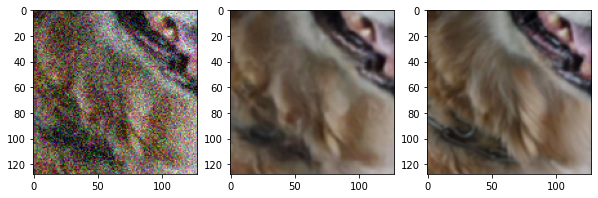

In [7]:
#@title Denoising example
sample = next(iter(trainloader))
x = sample['noisy'][0:1]
target = sample['target'][0:1]
with torch.no_grad():
    output = model(x.to(device))

x = x.clip(0,1).permute(0,2,3,1).squeeze()
output = output.clip(0,1).cpu().permute(0,2,3,1).squeeze()
target = target.permute(0,2,3,1).squeeze()

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(output, target)))
plt.figure(figsize=(10,32))
plt.subplot(1,3,1); plt.imshow(x) 
plt.subplot(1,3,2); plt.imshow(output)
plt.subplot(1,3,3); plt.imshow(target)
plt.show()

###Plug and play examples

####Load test image

In [8]:
# Get sample
test_image = Image.open('test_image.png').convert("RGB")
test_image = dataset.test_transform(test_image)
# test_image = dataset[1231]['target'] # from dataset
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)

####Motion deblur

  0%|          | 0/50 [00:00<?, ?it/s]

PSNR [dB]: 47.58


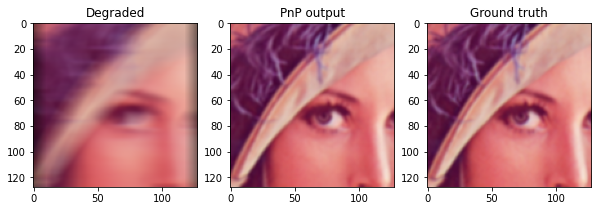

In [13]:
# Motion deblur
kernel_size = 21
kernel_motion_blur = torch.zeros((kernel_size, kernel_size))
kernel_motion_blur[int((kernel_size-1)/2)] = torch.ones(kernel_size)
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x.cpu(), test_image.cpu())))
plt.figure(figsize=(10,5))
plt.subplot(1,3,1); plt.imshow(y.permute(0,2,3,1).squeeze().cpu()); plt.title('Degraded')
plt.subplot(1,3,2); plt.imshow(x.permute(0,2,3,1).squeeze().cpu()); plt.title('PnP output')
plt.subplot(1,3,3); plt.imshow(test_image.permute(0,2,3,1).squeeze().cpu()); plt.title('Ground truth')
plt.show()

####Inpainting

  0%|          | 0/100 [00:00<?, ?it/s]

PSNR [dB]: 35.62


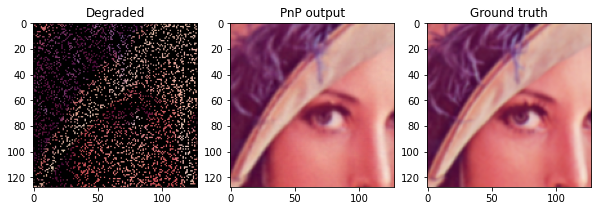

In [10]:
# Inpainting
mask = torch.rand(1,1,h,w).to(device)
mask = mask < 0.2

def forward(x):
    return x*mask
forward_adjoint = forward

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model, num_iter=100)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x.cpu(), test_image.cpu())))
plt.figure(figsize=(10,5))
plt.subplot(1,3,1); plt.imshow(y.permute(0,2,3,1).squeeze().cpu()); plt.title('Degraded')
plt.subplot(1,3,2); plt.imshow(x.permute(0,2,3,1).squeeze().cpu()); plt.title('PnP output')
plt.subplot(1,3,3); plt.imshow(test_image.permute(0,2,3,1).squeeze().cpu()); plt.title('Ground truth')
plt.show()

In [11]:
#@title Save model
# Save model
torch.save(model.state_dict(), './denoiser.pth')